In [44]:
import sys
sys.path.append('../..')

import eeg_decoder
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import scipy.stats as sista
from statsmodels.stats.multitest import multipletests

import scipy.io as io

np.random.seed(42)
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns

from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
OVERWRITE = False
np.random.seed(42)

In [8]:
experiment_name = 'B01'
data_dir = './data'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])
eyefiles = sorted(list(exp.data_dir.glob('*eyedata*.mat')))

In [9]:
eyefiles

[PosixPath('data/B01_01 _eyedata.mat'),
 PosixPath('data/B01_02 _eyedata.mat'),
 PosixPath('data/B01_03 _eyedata.mat'),
 PosixPath('data/B01_05 _eyedata.mat'),
 PosixPath('data/B01_07 _eyedata.mat'),
 PosixPath('data/B01_08 _eyedata.mat'),
 PosixPath('data/B01_11 _eyedata.mat'),
 PosixPath('data/B01_12 _eyedata.mat'),
 PosixPath('data/B01_13 _eyedata.mat'),
 PosixPath('data/B01_14 _eyedata.mat'),
 PosixPath('data/B01_15 _eyedata.mat'),
 PosixPath('data/B01_16 _eyedata.mat'),
 PosixPath('data/B01_17 _eyedata.mat')]

In [49]:
time_window = 25 
time_step = 25
trial_bin_size = 15 
n_splits = 1000

stim_off = 500  # ms

group_dict = OrderedDict([('SS1_col',[11]),('SS3_col',[13]), ('SS1_ori',[21]),('SS3_ori',[23])])

name_map = {11:'SS1 Color', 13:'SS3 Color', 21:'SS1 Orientation', 23:'SS3 Orientation'}

In [50]:
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)
clfr_eyes = eeg_decoder.Classification(wrangl,exp.nsub)

In [51]:
mean_dists = defaultdict(list)
for isub in range(exp.nsub):

    print(isub)
    xdata_eeg,ydata = exp.load_eeg(isub)
    eyedata = io.loadmat(eyefiles[isub])['eyedata']
    eyedata = np.rollaxis(eyedata, -1)  # reorder to trial, feat, time
    # if isub!= 14:  # no correspondence between number of eye trials and number of eeg trials
    assert eyedata.shape[0] == ydata.shape[0]
    assert eyedata.shape[2] == xdata_eeg.shape[2]
    assert eyedata.shape[1] == 6 # 2 EOG, l-x, l-y, r-x, r-y
    eyedata = eyedata[:, 2:, :]  # drop EOGs

    # drop to just the delay period
    eyedata = eyedata[:,:, exp.info['times'] > stim_off]

    x_locs = eyedata[:, ::2, :].mean(1)
    y_locs = eyedata[:, 1::2, :].mean(1)

    # get average distance from fixation over time
    dists = np.sqrt(x_locs**2 + y_locs**2)

    # see how much the eyes moved, on average
    x_diffs = np.diff(x_locs, 1)  # get differences across time
    y_diffs = np.diff(y_locs, 1)

    euclid_diffs = np.sqrt(x_diffs**2 + y_diffs**2)  # get euclidean distance between timepoints
    euclid_diffs = euclid_diffs.sum(1)  # sum over time


    mean_dists['Sub'] = np.concatenate([mean_dists['Sub'], [isub] * dists.shape[0]])
    mean_dists['Mean Dist'] = np.concatenate([mean_dists['Mean Dist'], dists.mean(1)])
    mean_dists['Condition'] = np.concatenate([mean_dists['Condition'], ydata])
    mean_dists['X Loc'] = np.concatenate([mean_dists['X Loc'], x_locs.mean(1)])
    mean_dists['Y Loc'] = np.concatenate([mean_dists['Y Loc'], y_locs.mean(1)])
    mean_dists['Distance Traveled'] = np.concatenate([mean_dists['Distance Traveled'], euclid_diffs])

dist_df = pd.DataFrame(mean_dists)
dist_df['Condition'] = dist_df['Condition'].map(name_map)  # get readable condition names
dist_df = dist_df[~dist_df['Condition'].isin(['SS0_ori', 'SS0_mot'])]

0
1
2
3
4
5
6
7
8
9
10
11
12


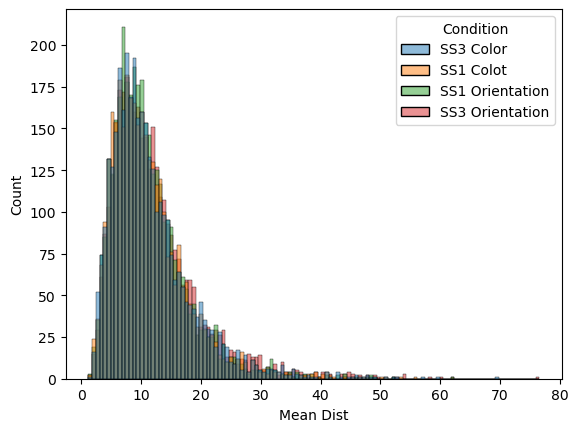

In [48]:
_ = sns.histplot(data=dist_df, x='Mean Dist', hue='Condition')

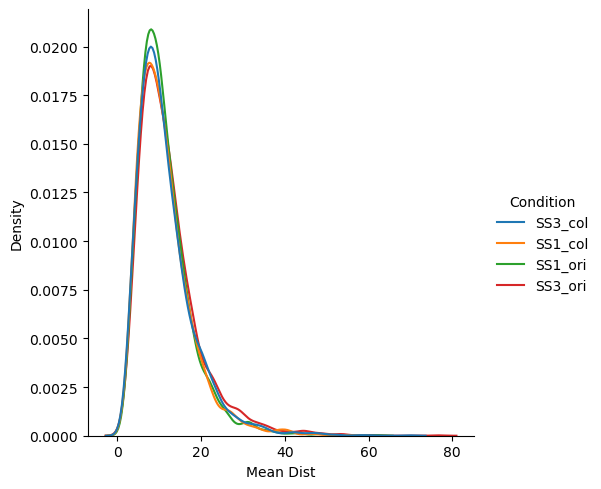

In [27]:
_ = sns.displot(data=dist_df, x='Mean Dist', hue='Condition', kind='kde')

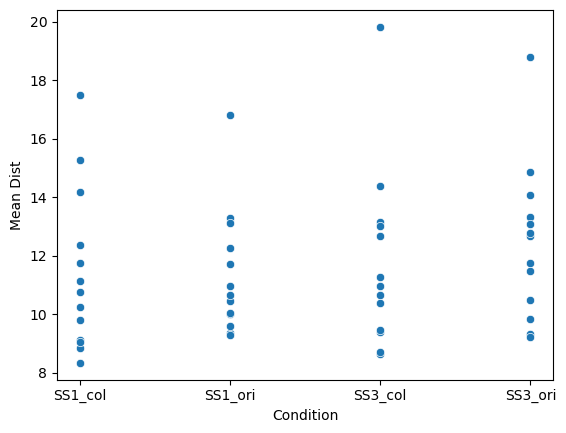

In [28]:
mean_dist_df = dist_df.groupby(['Sub', 'Condition']).mean().reset_index()
_ = sns.scatterplot(data=mean_dist_df, x='Condition', y='Mean Dist')

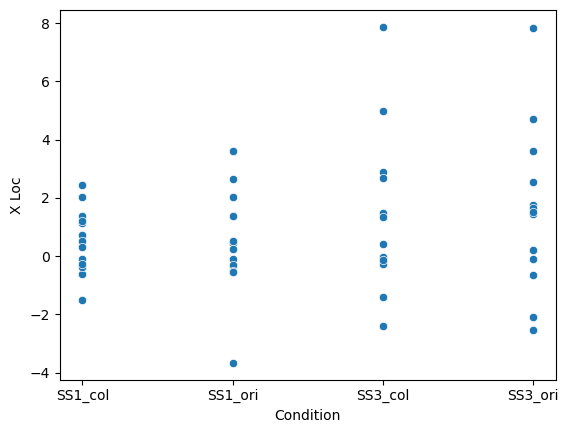

In [29]:
_ = sns.scatterplot(data=mean_dist_df, x='Condition', y='X Loc')

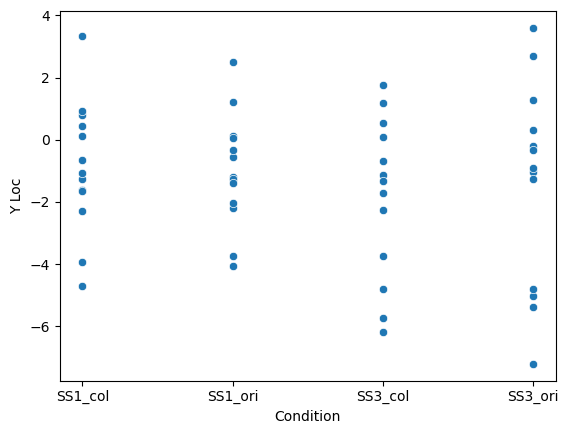

In [30]:
_ = sns.scatterplot(data=mean_dist_df, x='Condition', y='Y Loc')

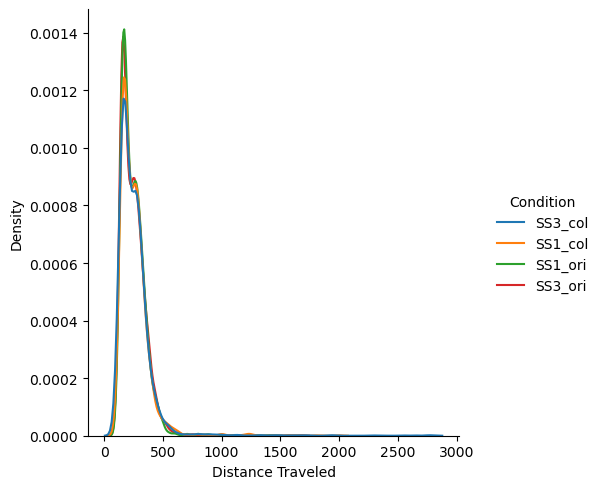

In [31]:
_ = sns.displot(data=dist_df, x='Distance Traveled', hue='Condition', kind='kde')

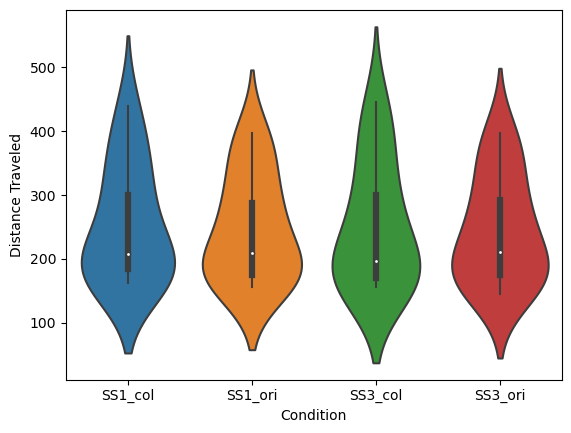

In [32]:
_ = sns.violinplot(data=mean_dist_df, x='Condition', y='Distance Traveled')

In [52]:
dist_df['Set Size'] = np.where(dist_df['Condition'].str.contains('SS1'), 1, 3)
dist_df['Attended Feature'] = np.where(dist_df['Condition'].str.contains('Color'), 'Color', 'Motion')

In [53]:
dist_df.groupby(['Sub', 'Set Size', 'Attended Feature', 'Condition']).mean()

Mean Dist     X Loc     Y Loc  \
Sub  Set Size Attended Feature Condition                                        
0.0  1        Color            SS1 Color        12.376147 -0.618146 -1.275982   
              Motion           SS1 Orientation  12.278223 -0.329970 -1.196868   
     3        Color            SS3 Color        12.685971 -2.386750 -1.132745   
              Motion           SS3 Orientation  13.335036 -2.523703 -0.199550   
1.0  1        Color            SS1 Color         8.344989  0.725737  0.127014   
              Motion           SS1 Orientation   9.377804 -0.081940  0.111027   
     3        Color            SS3 Color         8.648891 -0.061860 -0.675758   
              Motion           SS3 Orientation   9.341484 -0.638770 -1.036995   
2.0  1        Color            SS1 Color        11.146996  2.433945 -1.611117   
              Motion           SS1 Orientation  10.025538  1.377263 -1.263507   
     3        Color            SS3 Color        10.396519  2.880228 -1.709276   
              Motion           SS3 Orientation  10.479322  1.758931 -1.263161   
3.0  1        Color            SS1 Color         9.117963 -0.095558  0.429805   
              Motion           SS1 Orientation   9.608237  0.446892  0.054543   
     3        Color            SS3 Color         9.411002  0.419308  0.100724   
              Motion           SS3 Orientation   9.229508  0.198690  0.302997   
4.0  1        Color            SS1 Color        14.187866 -1.512574 -3.942623   
              Motion           SS1 Orientation  13.280533 -3.659868 -3.740824   
     3        Color            SS3 Color        14.373341 -1.391451 -6.190886   
              Motion           SS3 Orientation  14.869289 -2.087949 -5.015649   
5.0  1        Color            SS1 Color        10.239598 -0.384259 -2.289960   
              Motion           SS1 Orientation  10.463576 -0.289405 -2.184196   
     3        Color            SS3 Color        10.974499 -0.019692 -4.795937   
              Motion           SS3 Orientation  11.482260  1.648073 -0.923730   
6.0  1        Color            SS1 Color         9.791286 -0.264923 -1.067173   
              Motion           SS1 Orientation  10.960595 -0.497732 -0.550751   
     3        Color            SS3 Color        11.261704  2.686775  0.550855   
              Motion           SS3 Orientation  12.662917  2.538899  3.603193   
7.0  1        Color            SS1 Color         8.857514  1.142235 -1.661742   
              Motion           SS1 Orientation   9.306135  0.254260 -2.049168   
     3        Color            SS3 Color         8.704010  1.467158 -2.272334   
              Motion           SS3 Orientation  12.768844  3.594427 -4.818333   
8.0  1        Color            SS1 Color        10.755207  0.523307  0.808835   
              Motion           SS1 Orientation  10.660992 -0.529287 -0.321085   
     3        Color            SS3 Color        10.656526 -0.285919 -3.739196   
              Motion           SS3 Orientation  11.766936  1.448139 -5.399592   
9.0  1        Color            SS1 Color        15.272030  2.032524  0.933638   
              Motion           SS1 Orientation  13.115628  2.648037  1.216211   
     3        Color            SS3 Color        13.141340  4.996338  1.165709   
              Motion           SS3 Orientation  14.075444  4.712101  2.695537   
10.0 1        Color            SS1 Color         9.052999  0.325278  3.331260   
              Motion           SS1 Orientation  10.039193  0.510847  2.499818   
     3        Color            SS3 Color         9.472334 -0.138620  1.764781   
              Motion           SS3 Orientation   9.835826 -0.103468  1.286935   
11.0 1        Color            SS1 Color        11.749902  1.387206 -0.644054   
              Motion           SS1 Orientation  11.732577  2.012311 -1.394080   
     3        Color            SS3 Color        13.014016  1.347181 -1.327026   
              Motion           SS3 Orientation  13.079812  1.509277 -0.319447  

In [59]:
palette = {
'SS1 Color': 'gold',
'SS3 Color': 'darkorange',
'SS1 Orientation': 'violet',
'SS3 Orientation': 'darkmagenta',
}

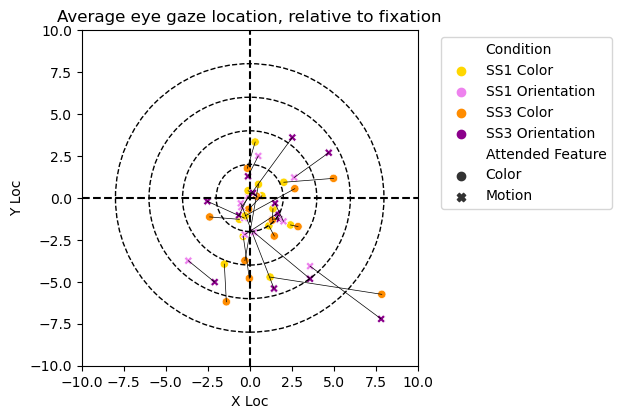

In [60]:
average_df = dist_df.groupby(['Sub', 'Set Size', 'Attended Feature', 'Condition']).mean().reset_index()
ax = sns.scatterplot(average_df,hue='Condition', x='X Loc', y='Y Loc', style='Attended Feature', palette=palette)
# add a line connecting SS1 and SS2 for each subject, within a given attended feature
plt.xlim(-10, 10)
plt.ylim(-10, 10)
for isub in average_df['Sub'].unique():
    for att_feat in average_df['Attended Feature'].unique():
        ss1 = average_df[(average_df['Sub'] == isub) & (average_df['Set Size'] == 1) & (average_df['Attended Feature'] == att_feat)]
        ss2 = average_df[(average_df['Sub'] == isub) & (average_df['Set Size'] == 3) & (average_df['Attended Feature'] == att_feat)]
        plt.plot([ss1['X Loc'].values[0], ss2['X Loc'].values[0]], [ss1['Y Loc'].values[0], ss2['Y Loc'].values[0]], color='black', linewidth=0.5)

# move legend outside of plot
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# add horizonal and vertical lines going through the origin
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# add dashed circles at 2 degrees, 4 degrees, and 6 degrees
for radius in [2, 4, 6, 8]:
    circle = plt.Circle((0, 0), radius, color='black', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

_ = plt.title('Average eye gaze location, relative to fixation')
plt.tight_layout()
ax.set_aspect('equal', adjustable='box')
plt.savefig('figures/eye_gaze_location.svg', format='svg')

In [ ]:
import pingouin as pg

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Set Size,6.397318,1,12,6.397318,9.734505,0.008855,0.008855,0.018605,1.0
1,Attended Feature,1.370191,1,12,1.370191,1.939781,0.188959,0.188959,0.004044,1.0
2,Set Size * Attended Feature,1.870069,1,12,1.870069,4.115978,0.065268,0.065268,0.005511,1.0


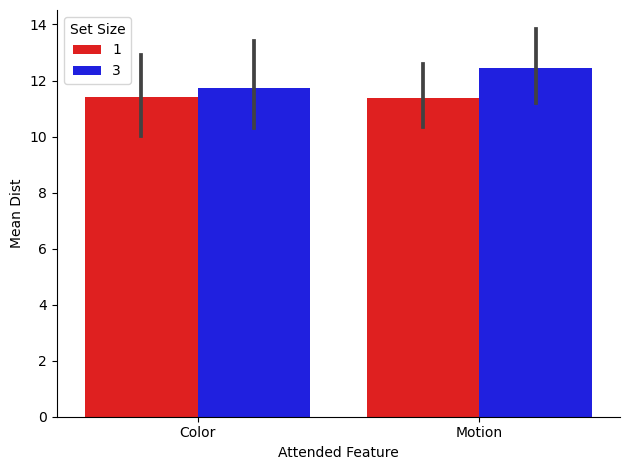

In [62]:
_ = sns.barplot(average_df, x='Attended Feature', y='Mean Dist', hue='Set Size', palette={1:'red', 3:'blue'})
sns.despine()
plt.tight_layout()
plt.savefig('figures/eye_gaze_anova_totalDist.svg', format='svg')

pg.rm_anova(data=dist_df, dv='Mean Dist', within=['Set Size', 'Attended Feature'], subject='Sub')


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Set Size,11.923780,1,12,11.923780,3.275989,0.095398,0.095398,0.047691,1.0
1,Attended Feature,0.021324,1,12,0.021324,0.038895,0.846958,0.846958,0.000090,1.0
2,Set Size * Attended Feature,0.300881,1,12,0.300881,0.516492,0.486101,0.486101,0.001262,1.0


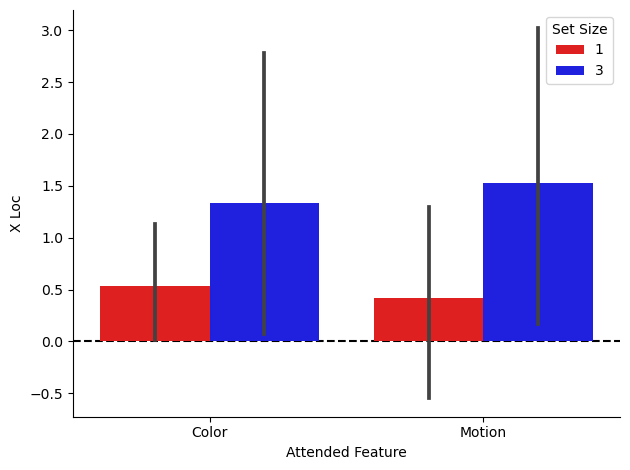

In [65]:
# repeat but looking at X pos and Y pos separately

# X pos
_ = sns.barplot(average_df, x='Attended Feature', y='X Loc', hue='Set Size', palette={1:'red', 3:'blue'})
plt.axhline(0, color='black', linestyle='--', zorder=0)
sns.despine()
plt.tight_layout()
plt.savefig('figures/eye_gaze_anova_Xloc.svg', format='svg')

pg.rm_anova(data=dist_df, dv='X Loc', within=['Set Size', 'Attended Feature'], subject='Sub')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Set Size,6.122755,1,12,6.122755,1.834022,0.200606,0.200606,0.019758,1.0
1,Attended Feature,0.372057,1,12,0.372057,0.337463,0.572046,0.572046,0.001223,1.0
2,Set Size * Attended Feature,0.945625,1,12,0.945625,1.368424,0.264793,0.264793,0.003103,1.0


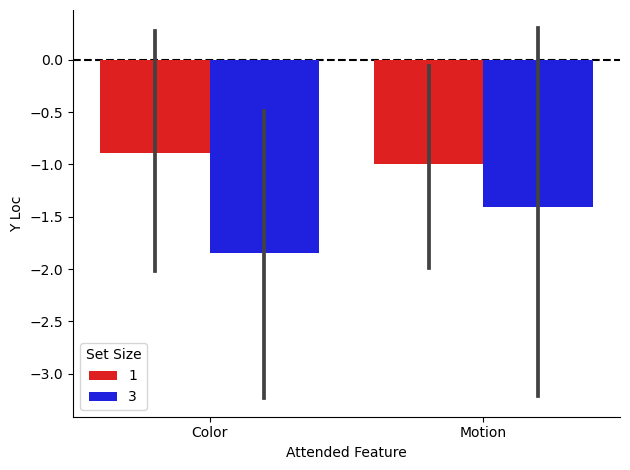

In [66]:
# Y pos

_ = sns.barplot(average_df, x='Attended Feature', y='Y Loc', hue='Set Size', palette={1:'red', 3:'blue'})
sns.despine()
plt.axhline(0, color='black', linestyle='--', zorder=0)
plt.tight_layout()
plt.savefig('figures/eye_gaze_anova_Yloc.svg', format='svg')

pg.rm_anova(data=dist_df, dv='Y Loc', within=['Set Size', 'Attended Feature'], subject='Sub')